In [2]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [81]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_disorder(W=10, t=1.5, nu=2., mu=0., U_0=1., delta=1., B=2., phi=0, salt='chizhang'):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [3]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [4]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_mu(W=10, t=1, nu=0.5, mu=0.5, mu_lead0=0.5, mu_lead1=0.5, delta=0.5, B=1, phi=0):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu_lead0)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu_lead1)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [5]:
print(make_system_mu())

<FiniteSystem with 12 sites, and 22 hoppings>


[[ 2.        +0.j          0.02      +0.j          0.        +0.j
  -0.01      +0.j         -1.31637384-0.71913831j -1.75516512-0.95885108j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.02      +0.j          2.        +0.j          0.01      +0.j
   0.        +0.j          1.75516512+0.95885108j -1.31637384-0.71913831j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.01      +0.j         -2.        +0.j
  -0.02      +0.j          0.        +0.j          0.        +0.j
   1.31637384-0.71913831j  1.75516512-0.95885108j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [-0.01      +0.j          0.        +0.j         -0.02      +0.j
  -2.        +0.j          0.        +0.j          0.        +0.j
  -1.75516512+0.95885108j  1.3163

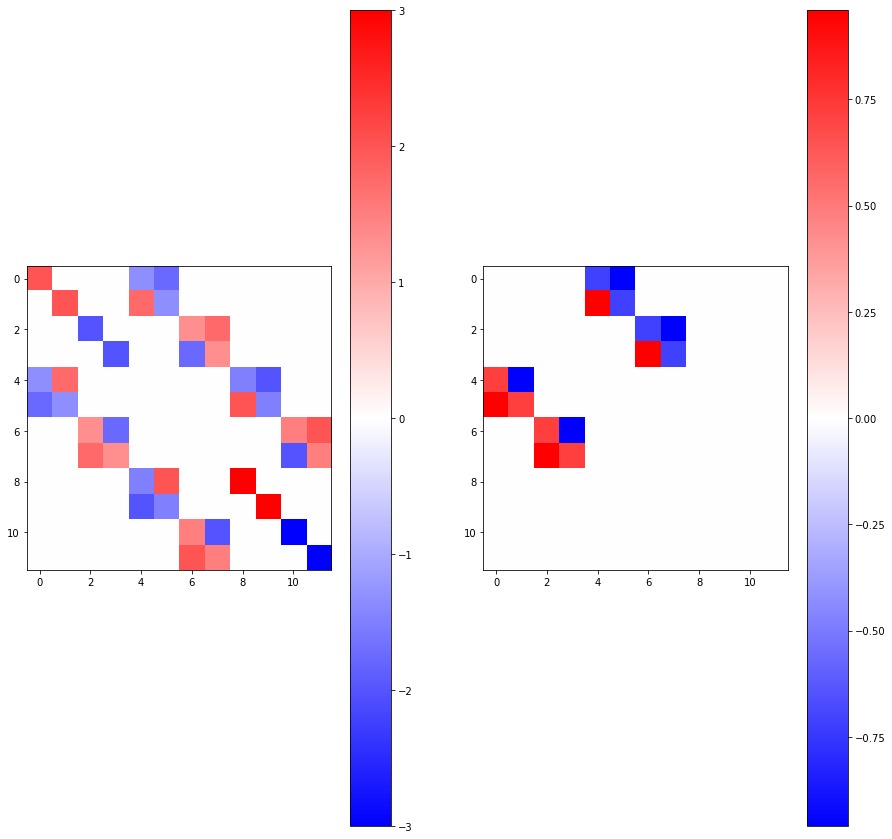

In [6]:
syst = make_system_mu(W=1, t=1.5, nu=2., mu=3., mu_lead0=1., mu_lead1=0., delta=1e-2, B=2e-2, phi=1.)
#kwant.plot(syst)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
print(ham_bdg)
eigenvalues, _ = spi.linalg.eigh(ham_bdg)
print(eigenvalues)

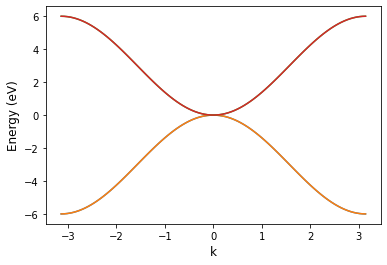

In [7]:
syst = make_system_mu(t=1.5, nu=0., mu=0., mu_lead0=0., mu_lead1=0., delta=0., B=0.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies0=[bands(k) for k in momenta]

x0=np.array(energies0)
en0=(x0)
#plt.ylim(-2,2)


plt.plot(momenta, en0)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

In [1]:
syst = make_system_mu(t=1.5, nu=2., mu=0., mu_lead0=0., mu_lead1=0., delta=0., B=0.)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies1=[bands(k) for k in momenta]

x1=np.array(energies1)
en1=(x1)
#plt.ylim(1.49,1.51)


plt.plot(momenta, en1)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

NameError: name 'make_system_mu' is not defined

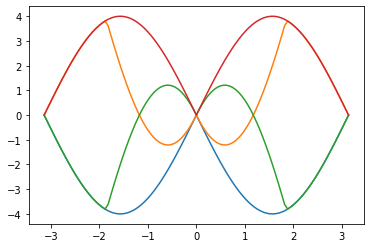

In [9]:
plt.plot(momenta, en1-en0)

## Boundstate Algo

In [14]:
def mu_scan(W=1, B=2e-3, t=1.5, nu=2., mu_leads=0., delta=1e-3, phi=0., mu_array=[-5., 5.]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(mu_array[0], mu_array[1], 101):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=i, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [15]:
e_array_ryan, psi_array_ryan = mu_scan(W=10, B=2., delta=1., phi=np.pi)

-5.0
[2.31492849e-09 2.31492849e-09]
-4.9
[2.32569637e-09 2.32569637e-09]
-4.8
[2.33728846e-09 2.33728846e-09]
-4.7
[4.46691295e-16 4.46691295e-16]
-4.6
[2.36642446e-09 2.36642446e-09]
-4.5
[2.38267388e-09 2.38267388e-09]
-4.4
[2.40124249e-09 2.40124249e-09]
-4.3
[2.4218694e-09 2.4218694e-09]
-4.2
[2.44467291e-09 2.44467291e-09]
-4.1
[-8.54351312e-16 -8.54351312e-16]
-4.0
[2.500344e-09 2.500344e-09]
-3.9
[2.53515198e-09 2.53515198e-09]
-3.8
[2.57747251e-09 2.57747251e-09]
-3.7
[2.62689794e-09 2.62689794e-09]
-3.5999999999999996
[2.68802464e-09 2.68802464e-09]
-3.5
[2.76565835e-09 2.76565835e-09]
-3.4
[-8.30668390e-01  2.87016367e-09  2.87016367e-09  8.30668390e-01]
-3.3
[-8.54007502e-01 -7.54250636e-01  3.01269695e-09  3.01269695e-09
  7.54250636e-01  8.54007502e-01]
-3.2
[-8.27391534e-01 -7.66964886e-01 -6.71614080e-01  3.22729845e-09
  3.22729845e-09  6.71614080e-01  7.66964886e-01  8.27391534e-01]
-3.0999999999999996
[-7.63297201e-01 -6.73513224e-01 -5.85889926e-01  3.58452943e-09
 

In [379]:
syst = make_system_mu(W=1, B=0., t=1.5, nu=0., mu=np.linspace(-5., 5., 101)[6], mu_lead0=0., mu_lead1=0., delta=0., phi=0.)
energies, wavefunctions = find_boundstates(syst, -0.1, 0.1, rtol=1e-2)
print(energies)

[]


In [284]:
print(np.linspace(-5., 5., 101)[6])

-4.4


In [418]:
def mu_scan_sans_gap(W=1, t=1.5, nu=0., e_range=5.1, rtol=1e-1, mu_array=[-5., 5.]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(mu_array[0], mu_array[1], 101):
        print(i)
        syst = make_system_mu(W=W, B=0., t=t, nu=nu, mu=i, mu_lead0=0., mu_lead1=0., delta=0., phi=0.)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [10]:
def phi_scan(W=1, B=2e-3, t=1.5, nu=2., mu_leads=0., delta=1e-3, mu=0., e_range=1.1e-3, rtol=1e-5, phi_array=[0., 4*np.pi]):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(phi_array[0], phi_array[1]):
        print(i)
        syst = make_system_mu(W=W, B=B, t=t, nu=nu, mu=mu, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=i)
        energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    #np.savetxt('./Keselman3/data/phi_scan(W=%s, B=%s, t=%s, nu=%s, mu_leads=%s, delta=%s, mu=%s)' % (W, B, t, nu, mu_leads, delta, mu), energy_arrays, delimiter=',')
    return energy_arrays, wavefunc_arrays

In [ ]:
e_show, phi_show = phi_scan(W=0, B=2e-3, t=1.5, nu=2., mu=0., delta=1e-3, e_range=1.1e-3, rtol=1e-5)
print(e_show)

In [ ]:
e_int, psi_int = phi_scan(B=2., delta=1., e_range=1.1, rtol=1e-2)
print(e_int)

In [ ]:
ex_inte = np.linspace(0., 4*np.pi, 101)
ey_inte = []
branch_count=0
for ey in e_int:
    if np.min(np.abs(ey))<1e-3:
        branch_count+=1
        ey_inte.append(((-1.)**branch_count)*np.min(np.abs(ey)))
    else:
        ey_inte.append(((-1.)**branch_count)*np.min(np.abs(ey)))
        
ey_inte2 = np.array(ey_inte)*np.cos(ex_inte/2.)
plt.plot(ex_inte, ey_inte2)
spi.integrate.simpson(ey_inte2, ex_inte)/(2.*np.pi)

In [200]:
np.min(np.abs(energies))

0.13188976107707417

In [457]:
def mu_W_scan(B=2e-3, t=1.5, nu=2., mu_leads=0., delta=1e-3, phi=0., e_range=1.1e-3, rtol=1e-5):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.arange(2, 12, 2):
        print('W='+str(i))
        energy_array=[]
        wavefunc_array=[]
        for j in np.linspace(-5, 5):
            print('mu='+str(j))
            syst = make_system_mu(W=i, B=B, t=t, nu=nu, mu=j, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
            energies, wavefunctions = find_boundstates(syst, -e_range, e_range, rtol=rtol)
            energy_array.append(energies)
            wavefunc_array.append(wavefunctions)
            print(energies)
        energy_arrays.append(energy_array)
        wavefunc_arrays.append(wavefunc_array)
    return energy_arrays, wavefunc_arrays

In [158]:
def delta_scan(W=1, t=1.5, nu=2., mu_leads=-4., mu=-4., phi=0., delta_range=[1e-3, 1]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(delta_range[0], delta_range[1]):
        print(i)
        print(2.*np.sqrt(mu**2.+i**2.))
        syst = make_system_mu(W=W, B=2.*np.sqrt(mu**2.+i**2.), t=t, nu=nu, mu=mu, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=i, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1.1*i, 1.1*i, rtol=1e-2*i)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [454]:
def delta_trivial_pi_scan(W=1, t=1.5, nu=2., mu_leads=0., mu=0., phi=np.pi, delta_range=[1e-3, 1]):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(delta_range[0], delta_range[1]):
        print(i)
        syst = make_system_mu(W=W, B=0., t=t, nu=nu, mu_lead0=mu_leads, mu_lead1=mu_leads, mu=mu, phi=phi, delta=i)
        energies, wavefunctions = find_boundstates(syst, -1.1*i, 1.1*i, rtol=1e-2*i)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [157]:
def delta_log_scan(W=1, t=1.5, nu=2., mu_leads=-4., mu=-4., phi=0., delta_log_range=[-5, 0]):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(delta_log_range[0], delta_log_range[1]):
        delta=10.**i
        print(delta)
        print(2.*np.sqrt(mu**2.+delta**2.))
        syst = make_system_mu(W=W, B=2.*np.sqrt(mu**2.+delta**2.), t=t, nu=nu, mu=mu, mu_lead0=mu_leads, mu_lead1=mu_leads, delta=delta, phi=phi)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [156]:
trial_run, trial_psi = delta_log_scan(delta_log_range=[-5, -3])
print(trial_run)

1e-05
8.000000000024999
[-3.57937795e-06  3.57937795e-06]
0.0001
8.0000000025
[-3.57932558e-05  3.57932558e-05]
[array([-3.57937795e-06,  3.57937795e-06]), array([-3.57932558e-05,  3.57932558e-05])]


In [65]:
trial_run[1]

[array([-2.35698674e-05,  2.35698674e-05]), array([-0.00039803,  0.00039803])]

In [61]:
np.arange(2, 6, 2)

array([2, 4])

In [31]:
np.savetxt('./Keselman3/mu_scan(W=1, B=2e-3, t=1.5, nu=2, mu_leads=0, delta=1e-3, phi=0)', e_array, delimiter=',')

ksidhd@!@#)(*)asfhas 12491 1


In [416]:
def mu_plot(energy_array, figure_title, mu_range=[-5., 5.], delta=1e-3, title=r'$W=1, B=2e-3, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=1e-3, \phi=0$'):
    ex = []
    ey = []
    mu_array = np.linspace(mu_range[0], mu_range[1], 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(mu_array[i])
            ey.append(energy_array[i][j])
           
    ey = np.array(ey)
    ey = ey
    plt.scatter(ex, ey)
    #plt.scatter(ex1, ey1, label=r'$\tau = 2/3$')
    #plt.scatter(ex2, ey2, label=r'$\tau = 1/3$')
    plt.xlim(mu_range[0], mu_range[1])
    #plt.ylim(2*min(ey), 2*max(ey))
    plt.xlabel(r'$\mu_{scat}$')
    plt.ylabel(r'$E$')
    plt.title(title)
    plt.savefig('./Keselman3/'+figure_title, dpi=300)

In [21]:
def mu_normal_plot(energy_array, figure_title, mu_range=[-5., 5.], delta=1e-3, title=r'$W=1, B=2e-3, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=1e-3, \phi=0$'):
    plt.plot(np.arange(mu_range[0], mu_range[1], 0.1), np.array(energy_array)/delta, color='b')
    plt.axhline(1, color='k', linestyle=':')
    plt.axhline(-1, color='k', linestyle=':')
    plt.xlabel(r'$\mu_{scat}$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman3/'+figure_title, dpi=300)

In [451]:
def phi_plot(energy_array, figure_title, phi_range=[0, 4*np.pi], delta=1e-3, title=r'$W=1, B=2e-3, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=1e-3, \mu=0$'):
    ex=[]
    ey=[]
    phi_array=np.linspace(phi_range[0], phi_range[1], 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi_array[i])
            ey.append(energy_array[i][j])
            
    ey = np.array(ey)/delta
    plt.scatter(ex, ey)
    plt.xlim(0, 4*np.pi)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman3/'+figure_title, dpi=300)

In [183]:
def delta_plot(energy_array, figure_title, delta_range=[0.001, 1], title=r'$W=1, B=2B_c, t=1.5, \nu=2, \mu_{lead0}=-4, \mu_{lead1}=-4, \mu=-4, \phi=0$'):
    ex=[]
    ey=[]
    delta_array = np.linspace(1e-3, 1)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(delta_array[i])
            ey.append(energy_array[i][j])
                
    ey=np.array(ey)/np.array(ex)
    plt.scatter(ex, ey)
    plt.xlim(delta_range[0], delta_range[1])
    plt.xlabel(r'$\Delta$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman3/'+figure_title, dpi=300)


In [186]:
def delta_log_plot(energy_array, figure_title, delta_range=[-5, 0], title=r'$W=1, B=2B_c, t=1.5, \nu=2, \mu_{lead0}=-4, \mu_{lead1}=-4, \mu=-4, \phi=0$'):
    ex=[]
    ey=[]
    delta_array = np.linspace(delta_range[0], delta_range[1])
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(delta_array[i])
            ey.append(energy_array[i][j])
                
    ey=np.array(ey)/(10.**np.array(ex))
    plt.scatter(ex, ey)
    plt.xlim(delta_range[0], delta_range[1])
    plt.xlabel(r'$log(\Delta)$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman3/'+figure_title, dpi=300)

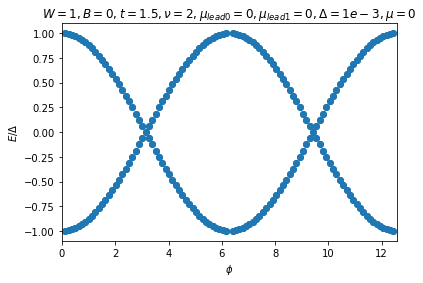

In [452]:
phi_plot(e_array13, 'phi_plot(B=0, Delta=1e-3)', title=r'$W=1, B=0, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=1e-3, \mu=0$')

In [ ]:
#W=1, B=2e-3
e_array, psi_array=mu_scan()
print(e_array)

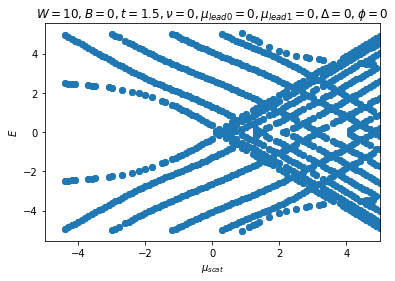

In [430]:
mu_plot(e_array12, 'mu_plot_sans_delta(W=10, nu=0)', title=r'$W=10, B=0, t=1.5, \nu=0, \mu_{lead0}=0, \mu_{lead1}=0, \Delta=0, \phi=0$')

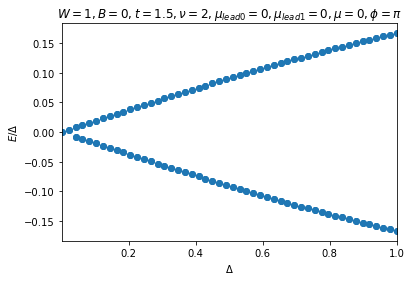

In [456]:
delta_plot(e_array14, 'delta_plot(W=1, B=0, phi=pi)', title=r'$W=1, B=0, t=1.5, \nu=2, \mu_{lead0}=0, \mu_{lead1}=0, \mu=0, \phi=\pi$')

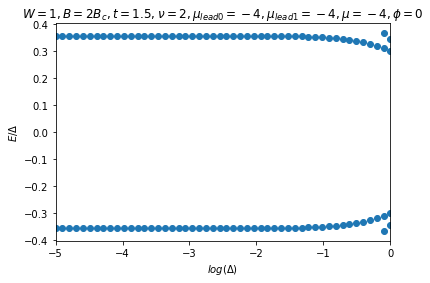

In [187]:
delta_log_plot(e_array6, 'delta_log_plot(W=1)', title=r'$W=1, B=2B_c, t=1.5, \nu=2, \mu_{lead0}=-4, \mu_{lead1}=-4, \mu=-4, \phi=0$')

In [ ]:
#W=1, B=2
e_array1, psi_array1=mu_scan(B=2.)
print(e_array1)

In [ ]:
#B=2
e_array2, psi_array2 = phi_scan(B=2.)
print(e_array2)

In [ ]:
#B=2e-3
e_array3, psi_array3 = phi_scan(B=2e-3)
print(e_array3)

In [ ]:
e_W_array, psi_W_array = mu_W_scan()

In [ ]:
# no spin orbit, trivial
e_W_array2, psi_W_array2 = mu_W_scan(B=0., nu=0.)

In [ ]:
#W=100
e_array4, psi_array4 = mu_scan(W=100, B=2e-3)
print(e_array4)

In [477]:
import pickle
pickle.dump(e_array14, open('./Keselman3/data/delta_trivial_pi_scan()', 'wb'))

In [478]:
trial_array=pickle.load(open('./Keselman3/data/delta_trivial_pi_scan()','rb'))
print(trial_array)

[array([1.87500065e-07, 1.87500065e-07]), array([8.57640524e-05, 8.57640524e-05]), array([-0.00032715, -0.00032715,  0.00032715,  0.00032715]), array([-0.00072418, -0.00072418,  0.00072418,  0.00072418]), array([-0.0012766, -0.0012766,  0.0012766,  0.0012766]), array([-0.00198403, -0.00198403,  0.00198403,  0.00198403]), array([-0.00284603, -0.00284603,  0.00284603,  0.00284603]), array([-0.00386201, -0.00386201,  0.00386201,  0.00386201]), array([-0.00503132, -0.00503132,  0.00503132,  0.00503132]), array([-0.00635321, -0.00635321,  0.00635321,  0.00635321]), array([-0.0078268, -0.0078268,  0.0078268,  0.0078268]), array([-0.00945117, -0.00945117,  0.00945117,  0.00945117]), array([-0.01122527, -0.01122527,  0.01122527,  0.01122527]), array([-0.01314798, -0.01314798,  0.01314798,  0.01314798]), array([-0.01521809, -0.01521809,  0.01521809,  0.01521809]), array([-0.01743432, -0.01743432,  0.01743432,  0.01743432]), array([-0.0197953, -0.0197953,  0.0197953,  0.0197953]), array([-0.0222

# delta plot for mu=-4

In [ ]:
e_array5, psi_array5 = delta_scan()
print(e_array5)

In [ ]:
e_array6, psi_array6 = delta_log_scan()
print(e_array6)

# mu scan for everything=0

In [ ]:
e_array7, psi_array7 = mu_scan_sans_gap(e_range=5.05)
print(e_array7)

# mu scan for everything = 0 except spin orbit

In [ ]:
e_array8, psi_array8 = mu_scan_sans_gap(e_range=5.05, nu=2.)

In [ ]:
e_array9, psi_array9 = mu_scan_sans_gap(e_range=6.05, nu=2.)

In [ ]:
e_array10, psi_array10 = mu_scan_sans_gap(e_range=5.05, nu=1.)

In [ ]:
e_array11, psi_array11 = mu_scan_sans_gap(e_range=5.05, nu=2., W=10)

In [ ]:
e_array12, psi_array12 = mu_scan_sans_gap(e_range=5.05, nu=0., W=10)

# Ryan

In [ ]:
e_array13, psi_array13 = phi_scan(B=0.)

In [ ]:
e_array14, psi_array14 = delta_trivial_pi_scan()

# mu scan for trivial without spin orbit

In [462]:
e_array15, psi_array15 = mu_scan(B=0., nu=1e-3)

-5.0
[]
-4.9
[]
-4.8
[]
-4.7
[]
-4.6
[]
-4.5
[]
-4.4
[]
-4.3
[]
-4.2
[]
-4.1
[]
-4.0
[]
-3.9
[]
-3.8
[]
-3.7
[]
-3.5999999999999996
[]
-3.5
[]
-3.4
[]
-3.3
[]
-3.2
[]
-3.0999999999999996
[]
-3.0
[]
-2.9
[]
-2.8
[]
-2.6999999999999997
[]
-2.5999999999999996
[]
-2.5
[]
-2.4
[]
-2.3
[]
-2.1999999999999997
[]
-2.0999999999999996
[]
-2.0
[]
-1.9
[]
-1.7999999999999998
[]
-1.6999999999999997
[]
-1.5999999999999996
[]
-1.5
[]
-1.4
[]
-1.2999999999999998
[]
-1.1999999999999997
[]
-1.0999999999999996
[]
-1.0
[]
-0.8999999999999995
[]
-0.7999999999999998
[]
-0.7000000000000002
[]
-0.5999999999999996
[]
-0.5
[]
-0.39999999999999947
[]
-0.2999999999999998
[]
-0.1999999999999993
[]
-0.09999999999999964
[]
0.0
[-0.00099759 -0.00099759  0.00099759  0.00099759]
0.10000000000000053
[]
0.20000000000000018
[]
0.3000000000000007
[]
0.40000000000000036
[]
0.5
[]
0.6000000000000005
[]
0.7000000000000002
[]
0.8000000000000007
[]
0.9000000000000004
[]
1.0
[]
1.1000000000000005
[]
1.2000000000000002
[]
1.30000

In [279]:
def f(x):
    return (x**2 - 1)

spi.optimize.ridder(f, 0, 2)

1.0